In [1]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import utils
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.utils import shuffle


# Setting random seeds to reduce the amount of randomness in the neural net weights and results
# The results may still not be exactly reproducible
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#!unzip "/content/drive/My Drive/Wiki.zip"

In [4]:
#Load MATLAB file 'imdb.mat' using the scipy.io module.
mat = scipy.io.loadmat('imdb_crop/imdb.mat')

#Display the contents of mat variable
display(mat)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Jan 17 11:30:27 2016',
 '__version__': '1.0',
 '__globals__': [],
 'imdb': array([[(array([[693726, 693726, 693726, ..., 726831, 726831, 726831]]), array([[1968, 1970, 1968, ..., 2011, 2011, 2011]], dtype=uint16), array([[array(['01/nm0000001_rm124825600_1899-5-10_1968.jpg'], dtype='<U43'),
                 array(['01/nm0000001_rm3343756032_1899-5-10_1970.jpg'], dtype='<U44'),
                 array(['01/nm0000001_rm577153792_1899-5-10_1968.jpg'], dtype='<U43'),
                 ...,
                 array(['08/nm3994408_rm926592512_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm943369728_1989-12-29_2011.jpg'], dtype='<U44'),
                 array(['08/nm3994408_rm976924160_1989-12-29_2011.jpg'], dtype='<U44')]],
               dtype=object), array([[1., 1., 1., ..., 0., 0., 0.]]), array([[array(['Fred Astaire'], dtype='<U12'),
                 array(['Fred Astaire'], dtype='<U12'),

In [5]:
# Convert the data into a pandas dataframe for easier handling and analysis

# Extract the data from the 'imdb' key in the provided data
imdb_data = mat['imdb'][0][0][0]

# Get the number of instances in the data
instances = imdb_data.shape[1]

# Define the column names for the dataframe
columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

# Create an empty dataframe with the specified columns and number of instances
df = pd.DataFrame(index=range(instances), columns=columns)

# Extract the data from "imdb" key in the loaded data
current_array = mat["imdb"][0][0]

# Assign the values from the current_array to the corresponding columns in the dataframe
for j, column in enumerate(columns[:len(current_array)]):
    df[column] = pd.DataFrame(current_array[j][0])



In [6]:
# 1.  Converting MATLAB datenum values in the 'dob' column of the DataFrame 'df' to exact dates and calculating the corresponding years for 'date_of_birth',
# followed by calculating the age by subtracting 'date_of_birth' from the 'photo_taken' column.
from datetime import datetime, timedelta

def datenum_to_year(datenum):
    epoch = datetime(1, 1, 1)  # Define the epoch as January 1, 0001
    ordinal = int(datenum) + 366  # Adjust for MATLAB datenum offset
    exact_date = datetime.fromordinal(ordinal) + timedelta(days=datenum % 1)  # Add fractional days
    return exact_date.year

# Convert MATLAB datenum values to years and assign the result to the 'date_of_birth' column
df['date_of_birth'] = df['dob'].apply(datenum_to_year)

# 2.  Calculate the age by subtracting 'date_of_birth' from the 'photo_taken' column
df['age'] = df['photo_taken'] - df['date_of_birth']

In [7]:
# 3.  Removing pictures that don't have faces based on the 'face_score' column
df = df.loc[df['face_score'] != -np.inf]

# 4.  Removing duplicate pictures based on the presence of a second face ('second_face_score' is NaN)
df = df.loc[df['second_face_score'].isna()]

# 5.  Removing pictures with age greater than 100 or less than or equal to 0
df = df.loc[df['age'] <= 100]
df = df.loc[df['age'] > 0]

In [8]:
# 6.  Droping rows with missing values in the 'gender' column
df.dropna(subset=['gender'], inplace=True)

# Displaying the value counts of the 'gender' column using value_counts() to understand the distribution of genders in the dataset.
gender_counts = df['gender'].value_counts()
display(gender_counts)

# NOTE: Gender: 1 - Male , 0 - Female

1.0    99875
0.0    81520
Name: gender, dtype: int64

In [9]:
# 7.  Filtering the DataFrame df based on a 'face_score' threshold of 1.5, removing rows with lower-quality face images.
df = df[df['face_score'] >= 1.5]

In [10]:
# 8. Converting each element in the 'full_path' column to a string by using str() and np.squeeze() within a list comprehension,
# the code assigns the resulting string representations to a new 'path' column in the DataFrame.
df['path'] = [str(np.squeeze(i)) for i in df['full_path']]
display(df)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age,path
3,693726,1968,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,1901,67,01/nm0000001_rm946909184_1899-5-10_1968.jpg
6,702986,2004,[02/nm0000002_rm1346607872_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[78.23569406558903, 52.335129377059346, 194.2...",3.479189,NaN,1926,78,02/nm0000002_rm1346607872_1924-9-16_2004.jpg
7,702986,2004,[02/nm0000002_rm1363385088_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[64.30867103752385, 64.30867103752385, 207.26...",3.870171,NaN,1926,78,02/nm0000002_rm1363385088_1924-9-16_2004.jpg
12,702986,1974,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,1926,48,02/nm0000002_rm221957120_1924-9-16_1974.jpg
13,702986,2007,[02/nm0000002_rm2287049216_1924-9-16_2007.jpg],0.0,[Lauren Bacall],"[[138.80620247948153, 33.92673852953003, 181.1...",3.482030,NaN,1926,81,02/nm0000002_rm2287049216_1924-9-16_2007.jpg
...,...,...,...,...,...,...,...,...,...,...,...
460715,726831,2011,[08/nm3994408_rm73386752_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[161, 161, 448, 448]]",4.801987,NaN,1991,20,08/nm3994408_rm73386752_1989-12-29_2011.jpg
460716,726831,2011,[08/nm3994408_rm744468480_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[300.756, 96.276, 422.592, 218.112]]",2.370091,NaN,1991,20,08/nm3994408_rm744468480_1989-12-29_2011.jpg
460718,726831,2011,[08/nm3994408_rm761245696_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[453.8981431333457, 77.96623712908011, 539.79...",3.845884,NaN,1991,20,08/nm3994408_rm761245696_1989-12-29_2011.jpg
460721,726831,2011,[08/nm3994408_rm943369728_1989-12-29_2011.jpg],0.0,[Jane Levy],"[[144.75225471724875, 126.76472287759263, 305....",4.450725,NaN,1991,20,08/nm3994408_rm943369728_1989-12-29_2011.jpg


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153626 entries, 3 to 460722
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dob                153626 non-null  int32  
 1   photo_taken        153626 non-null  uint16 
 2   full_path          153626 non-null  object 
 3   gender             153626 non-null  float64
 4   name               153626 non-null  object 
 5   face_location      153626 non-null  object 
 6   face_score         153626 non-null  float64
 7   second_face_score  0 non-null       float64
 8   date_of_birth      153626 non-null  int64  
 9   age                153626 non-null  int64  
 10  path               153626 non-null  object 
dtypes: float64(3), int32(1), int64(2), object(4), uint16(1)
memory usage: 12.6+ MB


In [12]:
folder_path = 'D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/crop_part1'  # Replace with the actual folder path

# Step 1: Use os.listdir to get a list of all image filenames in the folder
image_filenames = os.listdir(folder_path)

# Initialize an empty list to store individual DataFrames
dataframes_list = []

# Step 2: Loop through the filenames and extract age and gender information
for filename in image_filenames:
    # Split the filename using underscores to get age, gender, and other parts
    parts = filename.split('_')
    age = int(parts[0])
    gender = int(parts[1])

    # Create the full path to the image file
    image_path = 'crop_part1/'+filename

    # Step 3: Create a DataFrame for the current image and append it to the list
    image_df = pd.DataFrame({'path': [image_path], 'age': [age], 'gender': [gender]})
    dataframes_list.append(image_df)

temp_df = pd.concat(dataframes_list, ignore_index=True)

# Step 4: Concatenate all individual DataFrames into the final DataFrame
df = pd.concat([df, temp_df], ignore_index=True)

# Your DataFrame 'df' now contains the path, age, and gender information of the images
print(df.head())  # Check the first few rows of the DataFrame


        dob  photo_taken                                       full_path  \
0  693726.0       1968.0   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
1  702986.0       2004.0  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
2  702986.0       2004.0  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
3  702986.0       1974.0   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
4  702986.0       2007.0  [02/nm0000002_rm2287049216_1924-9-16_2007.jpg]   

   gender             name                                      face_location  \
0     1.0   [Fred Astaire]  [[622.8855056426588, 424.21750383700805, 844.3...   
1     0.0  [Lauren Bacall]  [[78.23569406558903, 52.335129377059346, 194.2...   
2     0.0  [Lauren Bacall]  [[64.30867103752385, 64.30867103752385, 207.26...   
3     0.0  [Lauren Bacall]  [[3173.144692593433, 401.0408365741791, 4059.1...   
4     0.0  [Lauren Bacall]  [[138.80620247948153, 33.92673852953003, 181.1...   

   face_score  second_face_score  date_of_birth  age  \


In [13]:
folder_path = 'D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/UTKFace'  # Replace with the actual folder path

# Step 1: Use os.listdir to get a list of all image filenames in the folder
image_filenames = os.listdir(folder_path)

# Initialize an empty list to store individual DataFrames
dataframes_list = []

# Step 2: Loop through the filenames and extract age and gender information
for filename in image_filenames:
    # Split the filename using underscores to get age, gender, and other parts
    parts = filename.split('_')
    age = int(parts[0])
    gender = int(parts[1])

    # Create the full path to the image file
    image_path = 'UTKFace/'+filename

    # Step 3: Create a DataFrame for the current image and append it to the list
    image_df = pd.DataFrame({'path': [image_path], 'age': [age], 'gender': [gender]})
    dataframes_list.append(image_df)

temp_df = pd.concat(dataframes_list, ignore_index=True)

# Step 4: Concatenate all individual DataFrames into the final DataFrame
df = pd.concat([df, temp_df], ignore_index=True)

# Your DataFrame 'df' now contains the path, age, and gender information of the images
print(df.head())  # Check the first few rows of the DataFrame


        dob  photo_taken                                       full_path  \
0  693726.0       1968.0   [01/nm0000001_rm946909184_1899-5-10_1968.jpg]   
1  702986.0       2004.0  [02/nm0000002_rm1346607872_1924-9-16_2004.jpg]   
2  702986.0       2004.0  [02/nm0000002_rm1363385088_1924-9-16_2004.jpg]   
3  702986.0       1974.0   [02/nm0000002_rm221957120_1924-9-16_1974.jpg]   
4  702986.0       2007.0  [02/nm0000002_rm2287049216_1924-9-16_2007.jpg]   

   gender             name                                      face_location  \
0     1.0   [Fred Astaire]  [[622.8855056426588, 424.21750383700805, 844.3...   
1     0.0  [Lauren Bacall]  [[78.23569406558903, 52.335129377059346, 194.2...   
2     0.0  [Lauren Bacall]  [[64.30867103752385, 64.30867103752385, 207.26...   
3     0.0  [Lauren Bacall]  [[3173.144692593433, 401.0408365741791, 4059.1...   
4     0.0  [Lauren Bacall]  [[138.80620247948153, 33.92673852953003, 181.1...   

   face_score  second_face_score  date_of_birth  age  \


In [14]:
display(df)

,dob,photo_taken,full_path,gender,name,face_location,face_score,second_face_score,date_of_birth,age,path
0,693726.0,1968.0,[01/nm0000001_rm946909184_1899-5-10_1968.jpg],1.0,[Fred Astaire],"[[622.8855056426588, 424.21750383700805, 844.3...",1.872117,NaN,1901.0,67,01/nm0000001_rm946909184_1899-5-10_1968.jpg
1,702986.0,2004.0,[02/nm0000002_rm1346607872_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[78.23569406558903, 52.335129377059346, 194.2...",3.479189,NaN,1926.0,78,02/nm0000002_rm1346607872_1924-9-16_2004.jpg
2,702986.0,2004.0,[02/nm0000002_rm1363385088_1924-9-16_2004.jpg],0.0,[Lauren Bacall],"[[64.30867103752385, 64.30867103752385, 207.26...",3.870171,NaN,1926.0,78,02/nm0000002_rm1363385088_1924-9-16_2004.jpg
3,702986.0,1974.0,[02/nm0000002_rm221957120_1924-9-16_1974.jpg],0.0,[Lauren Bacall],"[[3173.144692593433, 401.0408365741791, 4059.1...",4.096431,NaN,1926.0,48,02/nm0000002_rm221957120_1924-9-16_1974.jpg
4,702986.0,2007.0,[02/nm0000002_rm2287049216_1924-9-16_2007.jpg],0.0,[Lauren Bacall],"[[138.80620247948153, 33.92673852953003, 181.1...",3.482030,NaN,1926.0,81,02/nm0000002_rm2287049216_1924-9-16_2007.jpg
...,...,...,...,...,...,...,...,...,...,...,...
187109,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_3_20161220222856346.jpg.chip.jpg
187110,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_3_20170104222949455.jpg.chip.jpg
187111,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_4_20170103200637399.jpg.chip.jpg
187112,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,9,UTKFace/9_1_4_20170103200814791.jpg.chip.jpg


In [15]:
# Convert the gender values to integers before grouping
df['gender'] = df['gender'].astype(int)

print(df.dtypes)

dob                  float64
photo_taken          float64
full_path             object
gender                 int32
name                  object
face_location         object
face_score           float64
second_face_score    float64
date_of_birth        float64
age                    int64
path                  object
dtype: object


In [16]:

# Print unique values in the 'gender' column
gender_counts = df['gender'].value_counts()
print(gender_counts)

# Define the correct gender values that you want to keep
valid_genders = [0, 1]

# Filter the DataFrame to keep only the rows with valid gender values
df = df[df['gender'].isin(valid_genders)]

gender_counts = df['gender'].value_counts()
print(gender_counts)


1    98622
0    88491
3        1
Name: gender, dtype: int64
1    98622
0    88491
Name: gender, dtype: int64


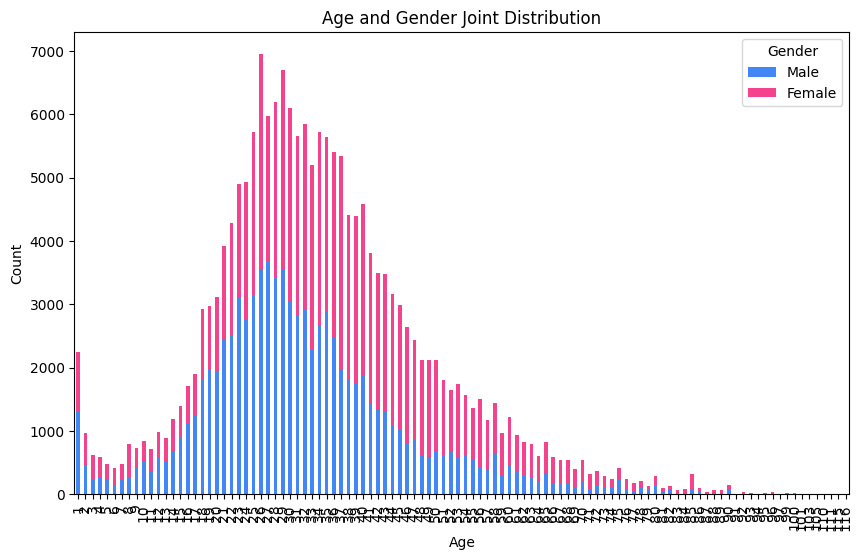

In [17]:

# Grouping the DataFrame 'df' by 'age' and 'gender' columns and counting the occurrences of each combination
age_groups = df.groupby(['age', 'gender']).size().unstack()

# Define custom colors for each gender category
colors = {0: '#4287f5', 1: '#f5428d'}

# Plotting the grouped data as a stacked bar chart with custom colors
age_groups.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in age_groups.columns])

# Adding a label to the x-axis
plt.xlabel('Age')

# Adding a label to the y-axis
plt.ylabel('Count')

# Adding a title to the plot
plt.title('Age and Gender Joint Distribution')

# Adding a legend to the plot with the title 'Gender'
plt.legend(title='Gender', labels=['Male', 'Female'])

# Displaying the plot
plt.show()

C:\Users\ndhu2\AppData\Local\Temp\ipykernel_31764\838797489.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age_uniform'] = ages_filtered


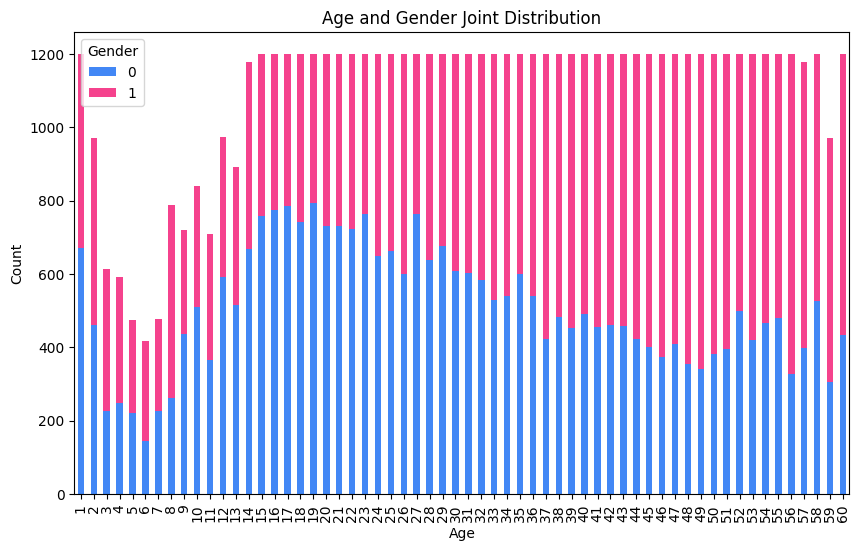

In [18]:
min_age = 0
max_age = 60

# Set the maximum number of records per age
max_records_per_age = 1200

# Filter the DataFrame to keep only records within the desired age range
df_filtered = df[(df['age'] >= min_age) & (df['age'] <= max_age)]

# Perform min-max scaling on the filtered age values to map them to the desired range
ages_filtered = df_filtered['age']
#ages_uniform = (ages_filtered - ages_filtered.min()) / (ages_filtered.max() - ages_filtered.min()) * (max_age - min_age) + min_age

# Update the DataFrame with the transformed age values
df_filtered['age_uniform'] = ages_filtered

# Perform downsampling to limit the number of records per age
df_downsampled = pd.DataFrame()
for age_val in df_filtered['age_uniform'].unique():
    df_age_group = df_filtered[df_filtered['age_uniform'] == age_val]
    if len(df_age_group) > max_records_per_age:
        df_age_group_downsampled = df_age_group.sample(max_records_per_age, random_state=21)
        df_downsampled = pd.concat([df_downsampled, df_age_group_downsampled])
    else:
        df_downsampled = pd.concat([df_downsampled, df_age_group])


# Grouping the DataFrame 'df' by 'age' and 'gender' columns and counting the occurrences of each combination
age_groups = df_downsampled.groupby(['age_uniform', 'gender']).size().unstack()
df = df_downsampled
# Define custom colors for each gender category
colors = {0: '#4287f5', 1: '#f5428d'}

# Plotting the grouped data as a stacked bar chart with custom colors
age_groups.plot(kind='bar', stacked=True, figsize=(10, 6), color=[colors[col] for col in age_groups.columns])

# Adding a label to the x-axis
plt.xlabel('Age')

# Adding a label to the y-axis
plt.ylabel('Count')

# Adding a title to the plot
plt.title('Age and Gender Joint Distribution')

# Adding a legend to the plot with the title 'Gender'
plt.legend(title='Gender')

# Displaying the plot
plt.show()

In [19]:
# Defining a function to return the class labels corresponding to the re-distributed 7 age-ranges.
def class_labels_reassign(age):
    if 1 <= age <= 2:
        return 0
    elif 3 <= age <= 9:
        return 1
    elif 10 <= age <= 20:
        return 2
    elif 21 <= age <= 27:
        return 3
    elif 28 <= age <= 45:
        return 4
    elif 46 <= age:
        return 5

#train_aug_df['target'] = train_aug_df['age'].map(class_labels_reassign)
#test_df['target'] = test_df['age'].map(class_labels_reassign)
df['target'] = df['age'].map(class_labels_reassign)

In [20]:
# Shuffling the DataFrame 'df' and creating a new DataFrame 'df_trial' containing half of the shuffled data, rounding the number of rows if needed.
df = shuffle(df)
df_trial = df[:round(df.shape[0])]

# Splitting the shuffled DataFrame 'df_trial' into 'train' and 'val' DataFrames, with approximately 70% for training and 30% for validation.
train = df_trial[:round(df_trial.shape[0]*0.7)]
val = df_trial[round(df_trial.shape[0]*0.7):]

# Printing the number of rows and columns in the 'train' and 'val' DataFrames, respectively.
print(train.shape)
print(val.shape)

(46056, 13)
(19739, 13)


In [21]:
# Converting the filenames and target class labels into lists for augmented train and test datasets.
train_aug_filenames_list = list(train['path'])
train_aug_labels_list = list(train['target'])
test_filenames_list = list(val['path'])
test_labels_list = list(val['target'])

# Creating tensorflow constants of filenames and labels for augmented train and test datasets from the lists defined above.
train_aug_filenames_tensor = tf.constant(train_aug_filenames_list)
train_aug_labels_tensor = tf.constant(train_aug_labels_list)
test_filenames_tensor = tf.constant(test_filenames_list)
test_labels_tensor = tf.constant(test_labels_list)

In [26]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.
# Changing the channels para in tf.io.decode_jpeg from 3 to 1 changes the output images from RGB coloured to grayscale.
num_classes = 6
def _parse_function(path, label):
    image_string = tf.io.read_file("D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/"+path)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale, channels=3 to convert to RGB.
    image_resized = tf.image.resize_with_pad(image_decoded, 200, 200)
    label = tf.one_hot(label, num_classes)
    return image_resized, label


# Getting the dataset ready for the neural network.
# Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.
train_aug_dataset = tf.data.Dataset.from_tensor_slices((train_aug_filenames_tensor, train_aug_labels_tensor))
train_aug_dataset = train_aug_dataset.map(_parse_function)
# train_aug_dataset = train_aug_dataset.repeat(3)
train_aug_dataset = train_aug_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
test_dataset = test_dataset.map(_parse_function)
# test_dataset = test_dataset.repeat(3)
test_dataset = test_dataset.batch(256)    # Same as batch_size hyperparameter in model.fit() below.

In [27]:
# Defining the architecture of the sequential neural network.
final_cnn = Sequential()
# Input layer with 32 filters, followed by an AveragePooling2D layer.
final_cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(200, 200, 1)))    # 3rd dim = 1 for grayscale images.
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# Three Conv2D layers with filters increasing by a factor of 2 for every successive Conv2D layer.
final_cnn.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
final_cnn.add(AveragePooling2D(pool_size=(2,2)))
# A GlobalAveragePooling2D layer before going into Dense layers below.
# GlobalAveragePooling2D layer gives no. of outputs equal to no. of filters in last Conv2D layer above (256).
final_cnn.add(GlobalAveragePooling2D())
# One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
final_cnn.add(Dense(128, activation='relu'))
# Output layer with 7 nodes (equal to the no. of classes).
final_cnn.add(Dense(6, activation='softmax'))
final_cnn.summary()

# Compiling the above created CNN architecture.
final_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Creating a TensorBoard callback object and saving it at the desired location.
tensorboard = TensorBoard(log_dir=f"D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/cnn_logs")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 198, 198, 32)      320       
                                                                 
 average_pooling2d_4 (Avera  (None, 99, 99, 32)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_5 (Conv2D)           (None, 97, 97, 64)        18496     
                                                                 
 average_pooling2d_5 (Avera  (None, 48, 48, 64)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 128)       73856     
                                                                 
 average_pooling2d_6 (Avera  (None, 23, 23, 128)      

In [29]:
# Creating a ModelCheckpoint callback object to save the model according to the value of val_accuracy.

checkpoint = ModelCheckpoint(filepath=f"D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/cnn_logs/age_model_checkpoint.h5",
                             monitor='val_accuracy',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1
                            )

# Fitting the above created CNN model.
final_cnn_history = final_cnn.fit(train_aug_dataset,
                                  batch_size=256,
                                  validation_data=test_dataset,
                                  epochs=40,
                                  callbacks=[tensorboard, checkpoint],
                                  shuffle=False    # shuffle=False to reduce randomness and increase reproducibility
                                 )

Epoch 1/40
180/180 [==============================] - ETA: 0s - loss: 1.5345 - accuracy: 0.3291
Epoch 1: val_accuracy improved from -inf to 0.36253, saving model to D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/cnn_logs\age_model_checkpoint.h5
180/180 [==============================] - 1016s 6s/step - loss: 1.5345 - accuracy: 0.3291 - val_loss: 1.4621 - val_accuracy: 0.3625
Epoch 2/40


c:\Users\ndhu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


180/180 [==============================] - ETA: 0s - loss: 1.4574 - accuracy: 0.3591
Epoch 2: val_accuracy improved from 0.36253 to 0.37743, saving model to D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/cnn_logs\age_model_checkpoint.h5
180/180 [==============================] - 920s 5s/step - loss: 1.4574 - accuracy: 0.3591 - val_loss: 1.4189 - val_accuracy: 0.3774
Epoch 3/40
180/180 [==============================] - ETA: 0s - loss: 1.4157 - accuracy: 0.3779
Epoch 3: val_accuracy improved from 0.37743 to 0.39678, saving model to D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/cnn_logs\age_model_checkpoint.h5
180/180 [==============================] - 918s 5s/step - loss: 1.4157 - accuracy: 0.3779 - val_loss: 1.3781 - val_accuracy: 0.3968
Epoch 4/40
180/180 [==============================] - ETA: 0s - loss: 1.3797 - accuracy: 0.3930
Epoch 4: val_accuracy improved from 0.39678 to 0.40671, saving model to D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/

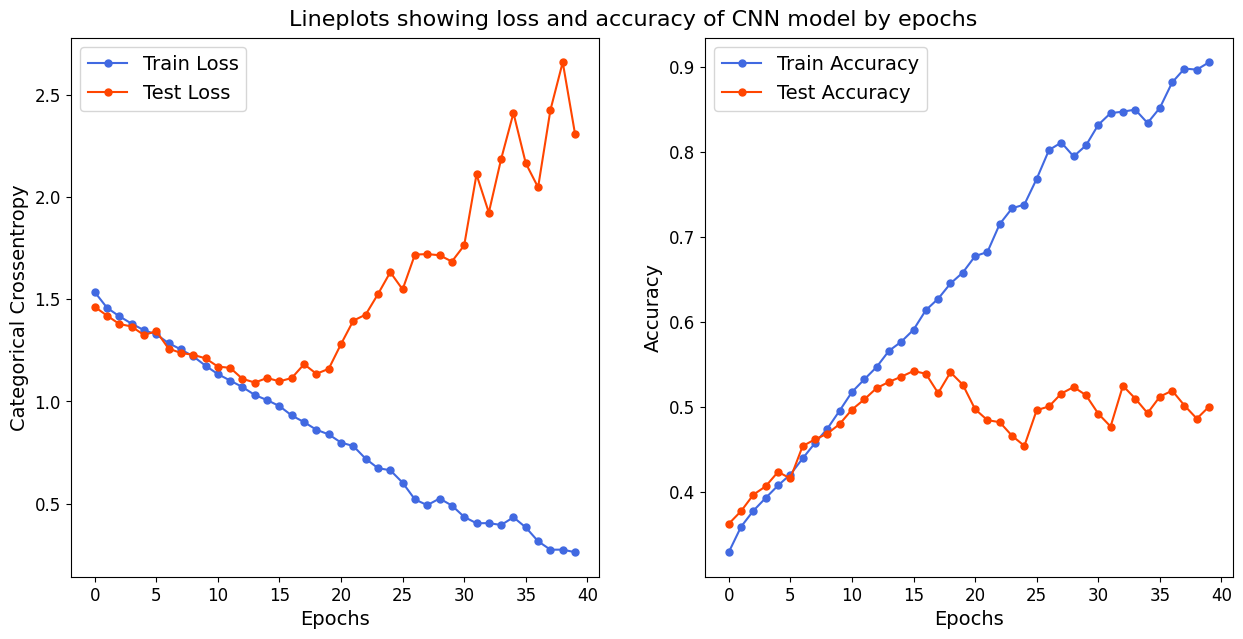

In [30]:
# Checking the train and test loss and accuracy values from the neural network above.
train_loss = final_cnn_history.history['loss']
test_loss = final_cnn_history.history['val_loss']
train_accuracy = final_cnn_history.history['accuracy']
test_accuracy = final_cnn_history.history['val_accuracy']

# Plotting a line chart to visualize the loss and accuracy values by epochs.
fig, ax = plt.subplots(ncols=2, figsize=(15,7))
ax = ax.ravel()
ax[0].plot(train_loss, label='Train Loss', color='royalblue', marker='o', markersize=5)
ax[0].plot(test_loss, label='Test Loss', color = 'orangered', marker='o', markersize=5)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Categorical Crossentropy', fontsize=14)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[1].plot(train_accuracy, label='Train Accuracy', color='royalblue', marker='o', markersize=5)
ax[1].plot(test_accuracy, label='Test Accuracy', color='orangered', marker='o', markersize=5)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
fig.suptitle(x=0.5, y=0.92, t="Lineplots showing loss and accuracy of CNN model by epochs", fontsize=16)


# Exporting plot image in PNG format.
plt.savefig('D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/cnn_logs/final_cnn_loss_accuracy.png', bbox_inches='tight');


78/78 [==============================] - 87s 1s/step - loss: 2.3071 - accuracy: 0.5005
CNN model loss 		= 2.307
CNN model accuracy 	= 0.501
78/78 [==============================] - 92s 1s/step
Normalized confusion matrix


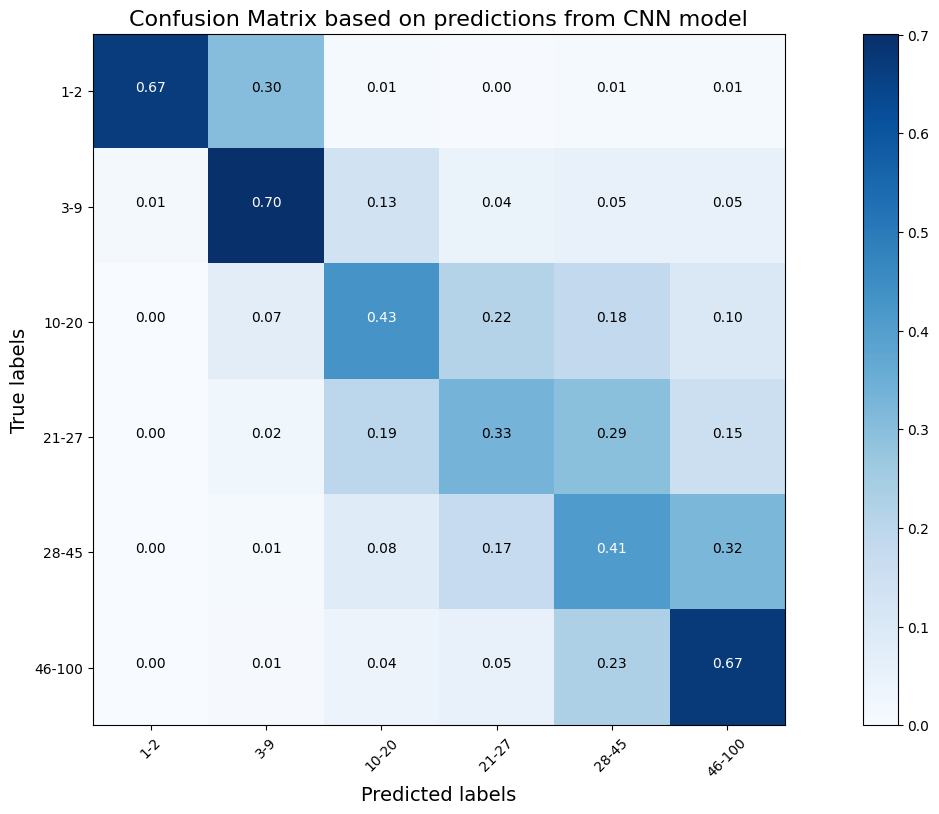

In [31]:
# Evaluating the model on test dataset.
final_cnn_score = final_cnn.evaluate(test_dataset, verbose=1)
# Printing the relevant score summary.
final_cnn_labels = final_cnn.metrics_names
print(f'CNN model {final_cnn_labels[0]} \t\t= {round(final_cnn_score[0], 3)}')
print(f'CNN model {final_cnn_labels[1]} \t= {round(final_cnn_score[1], 3)}')

# Saving the model as a h5 file for possible use later.
final_cnn.save(f"D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/age_model_acc_{round(final_cnn_score[1], 3)}.h5", save_format='h5')

# Generating predictions from the model above.
final_cnn_pred = final_cnn.predict(test_dataset)
final_cnn_pred = final_cnn_pred.argmax(axis=-1)
# Generating a confusion matrix based on above predictions.
conf_mat = confusion_matrix(test_labels_list, final_cnn_pred)

# Defining a function to plot the confusion matrix in a grid for easier visualization.
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True labels', fontsize=14)
    plt.xlabel('Predicted labels', fontsize=14)
    # Exporting plot image in PNG format.
    plt.savefig(f'D:/Users/ndhu2/Classes/Introduction to AI/Project/Models/M6/cnn_logs/{export_as}.png', bbox_inches='tight');

# Plotting the confusion matrix using the function defined above.
cm_plot_labels = ['1-2', '3-9', '10-20', '21-27', '28-45', '46-100']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=True,
                      title="Confusion Matrix based on predictions from CNN model",
                      export_as="final_cnn_conf_mat_norm"
                     )
plt.show()

In [1]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from lime import lime_image

# This function is used to load an image from a given file path, making it suitable for machine learning algorithms by resizing, converting, and normalizing the image.
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(200, 200), color_mode="grayscale")
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis=0)
    test_img /= 255
    return test_img

# Function to predict using your CNN model
def predict_with_model(images):
    prediction = final_cnn.predict(images)
    return prediction

# Load and preprocess the image using the loadImage function
desired_path = 'D:/Users/ndhu2/Classes/Introduction to AI/Project/imdb_crop/95/nm0000095_rm3916793088_1935-12-1_1972.jpg'
img_resized = loadImage(desired_path)

# Create the LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define the number of superpixels to be used for approximation
num_superpixels = 100

# Generate LIME explanation for the image
explanation = explainer.explain_instance(img_resized[0], predict_with_model, top_labels=5, num_samples=1000, num_features=num_superpixels)

# Get the image and mask for the explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=num_superpixels, hide_rest=True)

# Display the original image and the LIME explanation
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image.array_to_img(img[0]))
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
axs[1].axis('off')
axs[1].set_title('LIME Explanation')

plt.show()

# Predicting the age estimation for the image loaded using the loadImage function and stored in the variable img_resized.
prediction = final_cnn.predict(img_resized)
print("Predictions:", prediction)
print("Prediction:", np.argmax(prediction))

# Filter the DataFrame to get the desired record
desired_path = '95/nm0000095_rm3916793088_1935-12-1_1972.jpg'
filtered_df = df[df['path'] == desired_path]
display(filtered_df)

if not filtered_df.empty:
    # If you want to get all features of the record:
    record_features = filtered_df.iloc[0]  # Select the first row as a Series

    # If you want to get the 'age' and 'path' values separately:
    age_value = filtered_df['age'].iloc[0]
    path_value = filtered_df['path'].iloc[0]

    # Display the result
    print("All Features of the Record:")
    print(record_features)

    print("\nAge Value of the Record:", age_value)
    print("Path Value of the Record:", path_value)
else:
    print("No record found with the desired path:", desired_path)

c:\Users\ndhu2\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'np' is not defined